# Lightining and Early Stopping

In [ ]:
! pip install lightning

In [ ]:
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch import Trainer
from lightning.pytorch import LightningModule
from lightning.pytorch import Callback

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.06MB/s]


In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
class LightingModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 96),
            nn.ReLU(),
            nn.Linear(96, 48),
            nn.ReLU(),
            nn.Linear(48, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def training_step(self, batch, batch_idx):

        X, y = batch
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = self(X)
        loss = nn.CrossEntropyLoss()(pred, y)
        self.log('train_loss', loss)

        return loss

    def validation_step(self, batch, batch_idx):

        X, y = batch
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = self(X)
        loss = nn.CrossEntropyLoss()(pred, y)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

model = LightingModel().to(device)
print(model)

LightingModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=96, bias=True)
    (1): ReLU()
    (2): Linear(in_features=96, out_features=48, bias=True)
    (3): ReLU()
    (4): Linear(in_features=48, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)


In [ ]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,         # Number of epochs with no improvement to wait
    mode='min',           # 'min' for loss, 'max' for accuracy, etc.
    verbose=True,
    min_delta=0.005
)

# Instantiate the Trainer and pass the EarlyStopping callback
trainer = Trainer(
    max_epochs=10,
    callbacks=[early_stopping_callback]
)

# Train the model
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | flatten           | Flatten    | 0      | train
1 | linear_relu_stack | Sequential | 80.5 K | train
---------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 1.548
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 1.548


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.026 >= min_delta = 0.005. New best score: 1.522
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.005. New best score: 1.522


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.512
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.512


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.005 >= min_delta = 0.005. New best score: 1.507
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.005. New best score: 1.507


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.497
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 1.497


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# @title prediction grid function
def create_prediction_grid(model, dataset, width, height, device="cpu"):
    """
    Creates a grid of plots showing predictions of a PyTorch model on a given dataset.

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        dataset (torch.utils.data.Dataset): The dataset to use for plotting.  Must
            return (image, label) tuples.
        width (int): The width of the grid (number of columns).
        height (int): The height of the grid (number of rows).
        device (str, optional): The device to use for the model and data. Defaults to "cpu".

    Returns:
        matplotlib.figure.Figure: The matplotlib figure containing the grid of plots,
            or None if there's an error.

    Raises:
        ValueError: If the dataset doesn't return (image, label) tuples, or
                    if width or height are not positive.
        RuntimeError: If the model fails to make a prediction.
    """
    if not isinstance(width, int) or width <= 0:
        raise ValueError("Width must be a positive integer.")
    if not isinstance(height, int) or height <= 0:
        raise ValueError("Height must be a positive integer.")

    model.to(device)
    model.eval()  # Set the model to evaluation mode

    fig, axs = plt.subplots(height, width, figsize=(width * 2, height * 2))  # Adjust figure size for better viewing
    fig.tight_layout() # Add this to automatically adjust subplot parameters to give specified padding.

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=width * height, shuffle=False)
    # Get a single batch to fill the grid.
    try:
        images, labels = next(iter(data_loader))
    except StopIteration:
        print("Error: Dataset is empty.")
        return None
    except TypeError:
        raise ValueError("Dataset must return (image, label) tuples.")

    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():  # Disable gradient calculation for inference
        try:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
        except Exception as e:
            raise RuntimeError(f"Error during model prediction: {e}")

    # Ensure axs is treated as a 2D array even if width or height is 1.
    if height == 1:
        axs = np.array([axs]) if width > 1 else np.array([[axs]])
    if width == 1:
        axs = np.array([[ax] for ax in axs])


    for i in range(height):
        for j in range(width):
            index = i * width + j
            if index >= len(images):
                break # Stop if we've processed all images in the batch.

            image = images[index].cpu().numpy()
            label = labels[index].cpu().numpy()
            prediction = predicted[index].cpu().numpy()

            # Reshape the image for display (assuming it's MNIST)
            image = image.reshape(28, 28)

            ax = axs[i, j]
            ax.imshow(image, cmap='gray')  # Display the image
            ax.axis('off')  # Turn off axis labels

            title_color = 'green' if prediction == label else 'red'
            ax.set_title(f"label: {label} pred: {prediction}", color=title_color, fontsize=10) # Set font size for title

    plt.show()

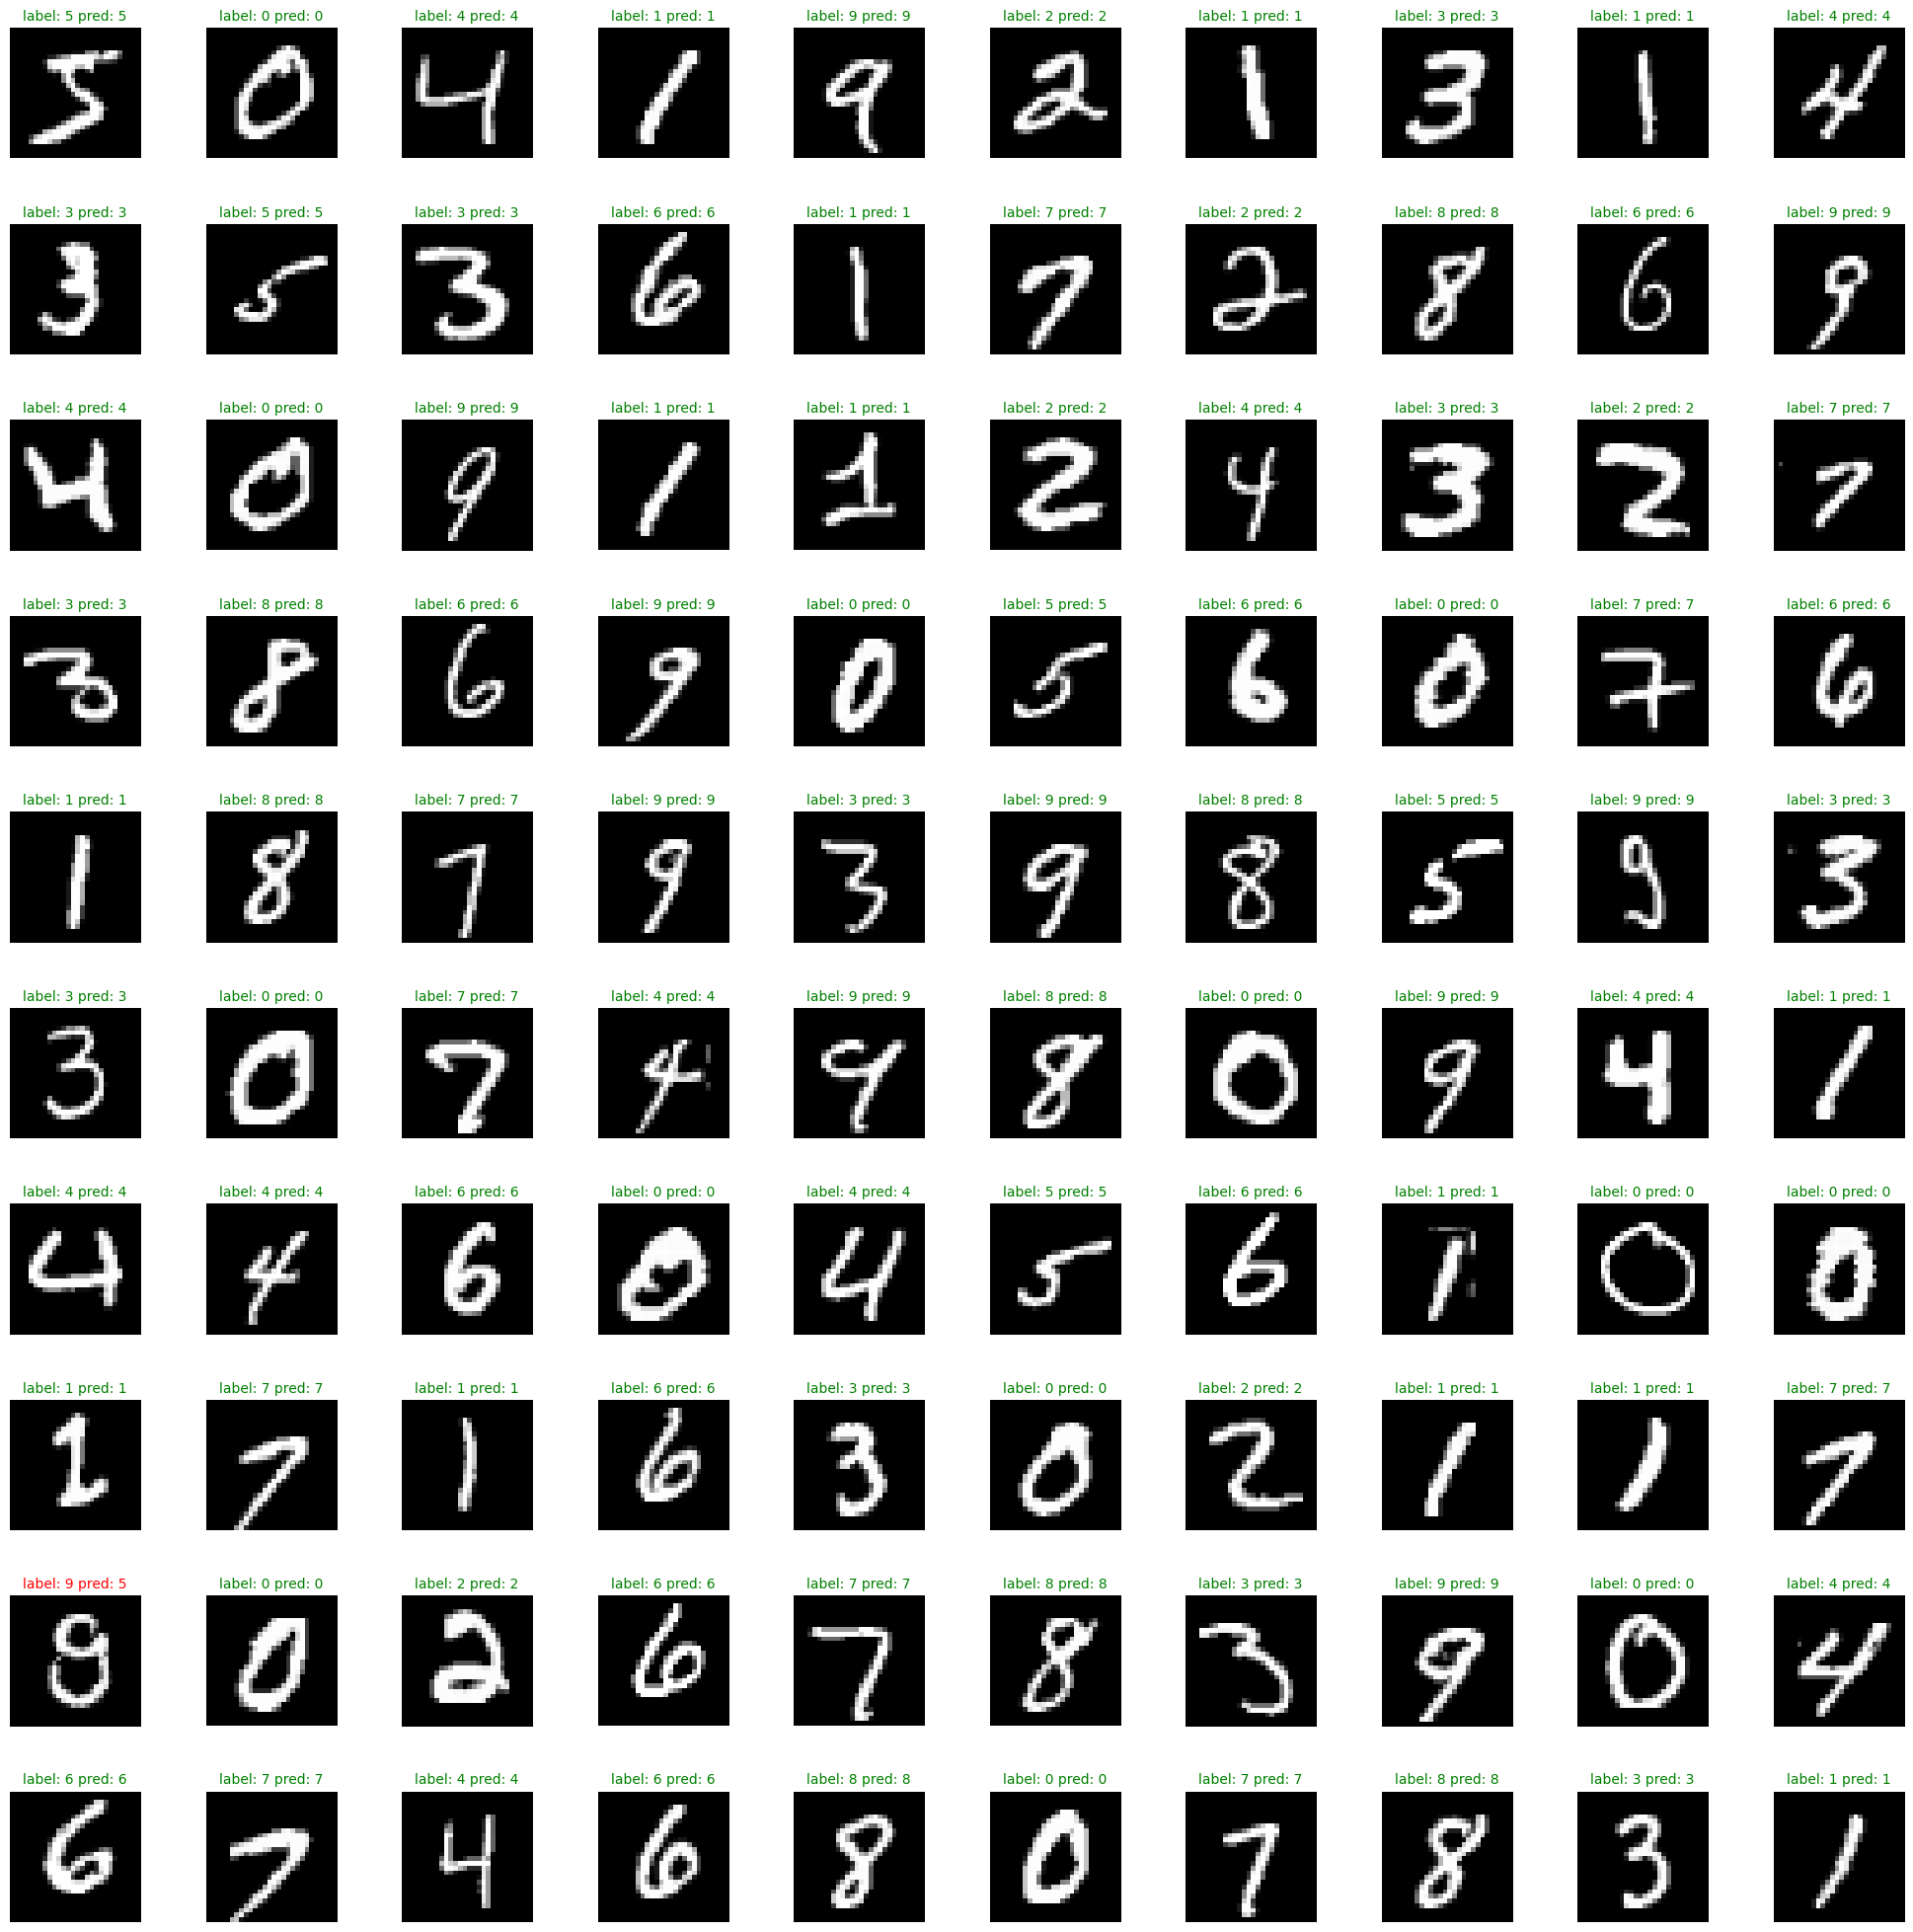

In [ ]:
create_prediction_grid(model, training_data, 10, 10, device = device)

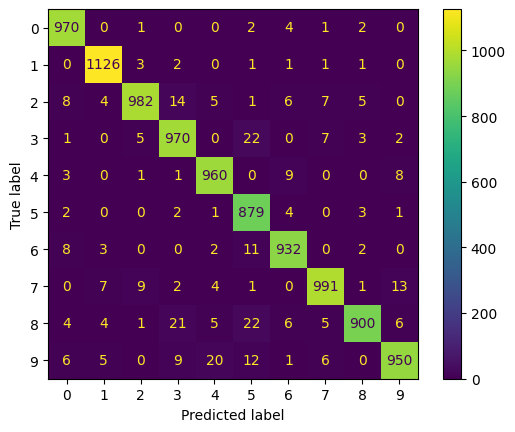

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get all data
all_inputs = []
all_labels = []

for i in range(len(test_data)):
    x, y = test_data[i]
    all_inputs.append(x)
    all_labels.append(y)

# Stack input tensors
inputs_tensor = torch.stack(all_inputs)  # Shape: [N, ...]
labels_tensor = torch.tensor(all_labels)

# Send to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
inputs_tensor = inputs_tensor.to(device)

# Predict
model.eval()
with torch.no_grad():
    outputs = model(inputs_tensor)
    test_preds = outputs.argmax(dim=1).cpu()  # shape: [N]

# Get ground-truth
test_labels = labels_tensor.cpu()  # shape: [N]

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
